In [1]:
import numpy as np
#import mdwc md_suit 
import mdwc.MD_suit.MD_suit as md_ft
#import mdwc md parameters reader
import mdwc.software_tools.abinit_controller as ac
#import ase calculators for energies and forces
import ase
from ase.calculators.emt import EMT
from ase.lattice.cubic import FaceCenteredCubic
from ase.calculators.lj import LennardJones


In [2]:
#start the sigma from stress from ase
def get_sigma(stress):
#stress= atoms.get_stress()# pressumable in eV/A^3
    sigma= np.array([[stress[0],stress[5],stress[4]], [stress[5], stress[1],stress[3]],\
                     [stress[4],stress[3],stress[2]]])
    return sigma

In [3]:
#starting ase potential
#3.446 angstrom
#8.5 angstrom
# 0.010768 eV
LJ= LennardJones(epsilon= 0.010768, sigma= 3.446, rc= 8.5)

#start structure from ase
atoms = FaceCenteredCubic(size=(3,3,3), symbol="Ar", pbc=True)
atoms.set_calculator(LJ)

In [4]:
# import parameters for the md, from the jn_test.md file 
Qmass, bmass, P_ext, dt, correc_steps, md_steps, abinit_steps= ac.get_md_parameters('jn_test.md')

numb_bond_cons, bool_bond_cons, numb_angl_cons, bool_angl_cons, \
numb_cell_para_cons, bool_cell_para_cons, numb_cell_angl_cons, bool_cell_angl_cons,\
volu_cons , bool_volu, numb_atom_fix_cons, bool_atom_fix_cons, bond_const, angl_const, cell_para_const,\
cell_angl_const, atom_fix_const, bond_valu, angl_valu, cell_para_valu,\
cell_angl_valu, volu_valu, atom_fix_valu, atom_fix_cord= ac.get_md_constrains('jn_test.md')

md_total_steps= md_steps*abinit_steps

temp_arra= ac.temp_data_reader('jn_test.md', md_total_steps)

#paremeters to start the thermostat degree of freedom (don't touch)
s_t=1.0 #thermostat degree of freedom
s_t_dot= 0.0#time derivative of thermostat degree of freedom



In [5]:
#this part is equivalent to ac.get_nat_mass_latvec_in_strten_in
#in the mdwc_ script
mass=   atoms.get_masses()#amu
h_t= atoms.cell#lattice vectors
nat= len(mass) #number of atoms in the system
strten_in= atoms.get_stress()

In [6]:
#this part is equivalent to ac.get_xred_fcart
#in the mdwc_ script
r_t= atoms.get_positions().T
x_t= np.dot(np.linalg.inv(h_t),r_t) # reduced coordinates
f_t= atoms.get_forces().T

In [7]:
#starting velocities
temp= temp_arra[0]
v_t= md_ft.npt_md_suit.init_vel_atoms(mass, temp, len(mass)) #atoms velociites
h_t_dot= md_ft.npt_md_suit.init_vel_lattice(bmass, temp, h_t)
x_t_dot= md_ft.npt_md_suit.get_x_dot(h_t, v_t, nat)

In [8]:
#start of the molecular dynamics
for i_abinit_step in range(abinit_steps):
#abinit_steps is the number of steps in which the forces and energy are
#going to be calculated.

    temp= temp_arra[i_abinit_step*md_steps]
    
    s_out, s_out_dot, pressure_out,\
    volu_out,bond_constrain_out,\
    cos_constrain_out, h_out,h_dot_out,\
    x_out, x_dot_out, v_out= md_ft.npt_md_suit.md_npt_constrains(h_t,x_t, x_t_dot, f_t, strten_in,\
                                                                            v_t,h_t_dot, bond_valu, angl_valu, \
                                                                            cell_para_valu,cell_angl_valu, volu_valu,\
                                                                            atom_fix_valu,atom_fix_cord, P_ext,mass, \
                                                                            Qmass, bmass, dt, temp, s_t, s_t_dot, \
                                                                            bond_const,angl_const, cell_para_const, \
                                                                            cell_angl_const, atom_fix_const,correc_steps, \
                                                                            md_steps, bool_bond_cons,bool_angl_cons, \
                                                                            bool_cell_para_cons,bool_cell_angl_cons, \
                                                                            bool_volu,bool_atom_fix_cons,volu_cons, \
                                                                            nat, numb_cell_angl_cons,numb_cell_para_cons, \
                                                                            numb_angl_cons, numb_bond_cons,numb_atom_fix_cons)    
    #set new step
    x_t= x_out
    x_t_dot= x_dot_out
    v_t= v_out
    h_t= h_out
    h_t_dot= h_dot_out
    s_t= s_out
    s_t_dot=s_out_dot
    
    #update the information for ase energy and forces calculations
    atoms.set_cell(h_t)
    r_t= np.dot(h_t,x_t)
    atoms.set_positions(r_t.T)
    strten_in= atoms.get_stress()
    f_t= atoms.get_forces().T

0
1
2
3
4
5
6
7
8
9


In [24]:
r_tx= np.dot(h_t,x_t)
print np.max(np.subtract(r_tx, r_t)), np.min(np.subtract(r_tx, r_t))

1.7763568394002505e-15 0.0


In [28]:
print r_tx.shape
xxx= atoms.get_positions()
print xxx.shape

(3, 108)
(108, 3)


In [25]:
for i in range(10):
    print r_tx[:,i]
    print r_t[:,i]
    print '***************'

[0. 0. 0.]
[0. 0. 0.]
***************
[2.63 2.63 0.  ]
[2.63 2.63 0.  ]
***************
[2.63 0.   2.63]
[2.63 0.   2.63]
***************
[0.   2.63 2.63]
[0.   2.63 2.63]
***************
[5.26 0.   0.  ]
[5.26 0.   0.  ]
***************
[7.89 2.63 0.  ]
[7.89 2.63 0.  ]
***************
[7.89 0.   2.63]
[7.89 0.   2.63]
***************
[5.26 2.63 2.63]
[5.26 2.63 2.63]
***************
[10.52  0.    0.  ]
[10.52  0.    0.  ]
***************
[13.15  2.63  0.  ]
[13.15  2.63  0.  ]
***************


In [4]:
#start structure from ase
atoms = FaceCenteredCubic(size=(3,3,3), symbol="Ar", pbc=True)
MaxwellBoltzmannDistribution(atoms, 100. * units.kB)
#view(atoms)
atoms.set_calculator(LJ)
Force= atoms.get_forces()
#print Force

In [3]:
print LJ.parameters

{'epsilon': 0.010768, 'sigma': 3.446, 'rc': 8.5}


In [5]:
#atoms.set_calculator(EMT())
#Force= atoms.get_forces()
#print Force

In [6]:
R0= atoms.get_positions()
print R0[1,:]
print R0[2,:]
print R0[3,:]

[2.63 2.63 0.  ]
[2.63 0.   2.63]
[0.   2.63 2.63]


In [7]:
R1= atoms.get_positions()
print R1[1,:]
print R1[2,:]
print R1[3,:]

[2.63 2.63 0.  ]
[2.63 0.   2.63]
[0.   2.63 2.63]


In [8]:
m=   atoms.get_masses() #amu
m= np.reshape(m, (len(m),1))
v_t= atoms.get_velocities()
p= np.multiply(m,v_t)
p_total= np.sum(np.multiply(m,v_t), axis=0, keepdims=True)
print 'temperature_before_normalization   ', atoms.get_temperature()
print 'total_p_no_normalized    ', p_total
p= p - np.divide(p_total,len(m))
print 'total_p_normalized    ',np.sum(p, axis=0)
v_t= np.divide(p,m)
#print v_t.shape
atoms.set_velocities(v_t)
print 'temperature_after_normalization   ', atoms.get_temperature()

temperature_before_normalization    100.93075998266384
total_p_no_normalized     [[ -3.20690445 -10.97582667  -1.87704886]]
total_p_normalized     [ 1.77635684e-15 -5.21804822e-15  3.44169138e-15]
temperature_after_normalization    99.81604745814343


In [9]:
h= atoms.cell
print h
r_t= atoms.get_positions()
v_t= atoms.get_velocities()
m=   atoms.get_masses() #amu
m= np.reshape(m, (len(m),1))
temp= atoms.get_temperature()
dt=0.01#1e-3 #1.0*units.fs
f= 3.0*len(m) #degres of freedom
s_t=1.0
s_t_dot= 0.0
Q= 0.1
F_t= atoms.get_forces()
K_ev_k= 8.6173303e-5

[[15.78  0.    0.  ]
 [ 0.   15.78  0.  ]
 [ 0.    0.   15.78]]


In [10]:
temp_arra= []
r_arra=[]
s_t_arra= []
s_t_dot_arra= []
kine_s=[]
kine_r_dot= []

In [11]:
temp_termostat_arra= 100.0*np.ones(500, float)#np.concatenate((300.0*np.ones(500, float),700.0*np.ones(500, float),1100.0*np.ones(500, float)))


In [12]:
temp_termostat_arra= np.concatenate((100.0*np.ones(1000, float),200.0*np.ones(1000, float),300.0*np.ones(1000, float)))


In [12]:
#np.sum(np.multiply(np.squeeze(m),np.dot(v_t,v_t.T)))/s_t +
for i, temp in enumerate(temp_termostat_arra):
    ar_t= np.divide(F_t,m)/(s_t**2.0) - 2.0*(s_t_dot/s_t**2.0)*v_t
    #asv= np.sum(np.multiply(m,np.multiply(v_t,v_t)))
    as_t= (np.sum(np.multiply(m,np.multiply(v_t,v_t)))/s_t - (f+1)*K_ev_k*temp/s_t)/Q
    
    r_t_dt= r_t + dt*(v_t/s_t) + 0.5*dt*dt*ar_t
    s_t_dt= s_t + dt*s_t_dot + 0.5*dt*dt*as_t
    atoms.set_positions(r_t_dt)
    F_t_dt= atoms.get_forces()
    #prediction correction 
    #prediction, calculate input for correction data
    v_c= s_t_dt*v_t/s_t + dt*s_t_dt*ar_t
    s_c_dot= s_t_dot + dt*as_t
    correc_steps= 8# number of correction steps
    #correction steps
    for _ in range(correc_steps):
        ar_c= np.divide(F_t_dt,m)/(s_t_dt**2.0) - 2.0*(s_c_dot/s_t_dt**2.0)*v_c
        as_c= (np.sum(np.multiply(m,np.multiply(v_c,v_c)))/s_t_dt - (f+1)*K_ev_k*temp/s_t_dt)/Q    
        v_c= v_t + 0.5*dt*(ar_c + ar_t)
        s_c_dot= s_t_dot + 0.5*dt*(as_c + as_t)
        
    r_t= r_t_dt
    s_t= s_t_dt
    v_t= v_c
    s_t_dot= s_c_dot
    F_t= F_t_dt
    atoms.set_positions(r_t)
    atoms.set_velocities(v_t)

    kine_s.append(np.sum(np.multiply(m,np.multiply(v_t,v_t))))
    #kine_r_dot.append(np.sum(np.multiply(m,np.multiply(r_dot,r_dot))))
    temp_arra.append(atoms.get_temperature())
    s_t_arra.append(s_t)
    s_t_dot_arra.append(s_t_dot)

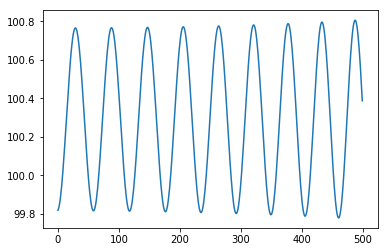

In [13]:
x= range(len(temp_termostat_arra)) 
plt.plot(x,temp_arra)
plt.show()

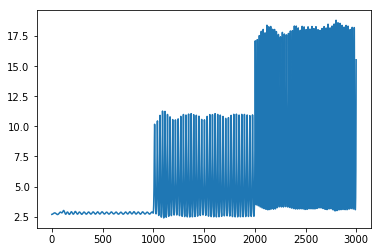

In [15]:
x= range(len(kine_s)) 
plt.plot(x,kine_s)
plt.show()

In [14]:
for i, tmep in enumerate(temp_arra):
    print i, '   ', tmep, '     ', s_t_arra[i]

0     103.38893834838852       1.0000000043001214
1     103.3889298564492       1.0000000172004777
2     103.38891570322768       1.0000000387010453
3     103.38889588874139       1.000000068801784
4     103.38887041301541       1.0000001075026388
5     103.38883927608245       1.0000001548035378
6     103.38880247798294       1.000000210704394
7     103.38876001876493       1.0000002752051038
8     103.38871189848417       1.0000003483055484
9     103.3886581172041       1.000000430005593
10     103.3885986749958       1.0000005203050861
11     103.38853357193798       1.0000006192038615
12     103.38846280811711       1.0000007267017366
13     103.3883863836272       1.0000008427985125
14     103.38830429857012       1.0000009674939752
15     103.38821655305517       1.000001100787894
16     103.38812314719954       1.000001242680023
17     103.38802408112792       1.0000013931701006
18     103.38791935497274       1.0000015522578483
19     103.38780896887411       1.0000017199429727

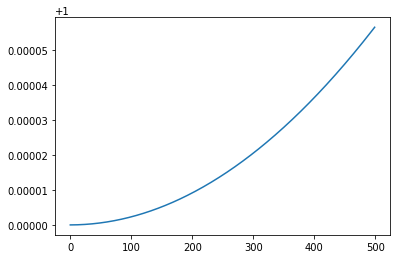

In [16]:
plt.plot(x,s_t_arra)
plt.show()

In [61]:
# 8.6173303×10−5
#1 Hartree = 27.2116 eV
K_ev_k= 8.6173303e-5
K_ha_k= K_ev_k/27.2116


292.33103214765885
9.673394154072172
0.3554878858307549
9.673394195850396


In [24]:
#Q value
t0= 3.0e-3
K_ev_k= 8.6173303e-5
temp_ext= np.array([100.0,500.0,1000.0,5000.0,10000.0])
print (t0**2.0)*(2.0*len(m)*K_ev_k*temp_ext)/(4.0*np.pi**2.0)

[1.25729007e-07 6.28645036e-07 1.25729007e-06 6.28645036e-06
 1.25729007e-05]


In [ ]:
asap3.LennardJones.